In [2]:
from preprocessing import Preprocessing
from utils.consts import *

processer = Preprocessing()

[2022-06-19 10:07:25] preprocessing.py:20 [INFO] - loading lc_data ...
[2022-06-19 10:07:26] preprocessing.py:33 [INFO] - loading lp_data ...
[2022-06-19 10:07:27] preprocessing.py:50 [INFO] - loading lclp_data ...
[2022-06-19 10:07:28] preprocessing.py:80 [INFO] - generating loan_data ...


In [3]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn import svm

In [4]:
# 分割数据
x, y = processer.loan.loc[:, processer.loan.columns != 'target'], processer.loan['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

confusion_matrix:
[[96201   197]
 [ 1736   432]]
accuracy_score:
0.9803887750339874
recall_score:
0.1992619926199262


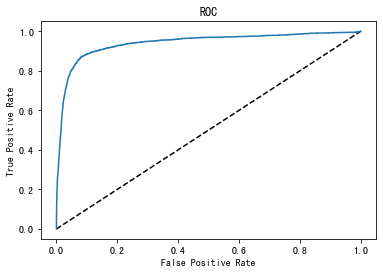

In [5]:
# 逻辑回归
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred_prob = logreg.predict_proba(x_test)[:, 1]
y_pred_value = logreg.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
print(f"confusion_matrix:\n{confusion_matrix(y_true=y_test,y_pred=y_pred_value)}")
print(f"accuracy_score:\n{accuracy_score(y_true=y_test,y_pred=y_pred_value)}")
print(f"recall_score:\n{recall_score(y_true=y_test,y_pred=y_pred_value)}")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig("images/logistic_regression_roc.png")
plt.show()

> 可以看到召回率比较低，准确率高是因为负样本本来就很少。观察数据可以发现，其中有些列，比如借款金额，数值比其他列大很多，这部分数据可能对训练过程造成很大影响，因此需要对数据进行归一化

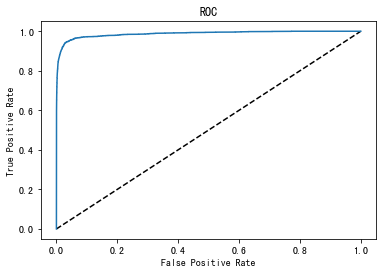

Accuracy : 0.9924
Precision : 0.918
Recall : 0.7177
AUC Score (train) : 0.987302


In [6]:
# 归一化
processer.loan = (processer.loan - processer.loan.min())/(processer.loan.max()-processer.loan.min())
# 重新分割数据
# 分割数据
x, y = processer.loan.loc[:, processer.loan.columns != 'target'], processer.loan['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# 再次训练、预测
# 逻辑回归
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred_prob = logreg.predict_proba(x_test)[:, 1]
y_pred_value = logreg.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig("images/logistic_regression_roc_norm.png")
plt.show()
print('Accuracy : %.4g' % accuracy_score(y_test, y_pred_value))
print('Precision : %.4g' % precision_score(y_test, y_pred_value))
print('Recall : %.4g' % recall_score(y_test, y_pred_value))
print('AUC Score (train) : %f' % roc_auc_score(y_test, y_pred_prob))

In [14]:
# smote过采样
from collections import Counter
from imblearn.over_sampling import SMOTE 
smote =  SMOTE(sampling_strategy=0.1,random_state=0)
x_smo, y_smo = smote.fit_resample(x_train, y_train) 
print('SMOTE过采样后标签数据统计:', Counter(y_smo))

# 用过采样后的数据逻辑回归
logreg_smo = LogisticRegression()
logreg_smo.fit(x_smo, y_smo)
y_pred_prob = logreg_smo.predict_proba(x_test)[:, 1]
y_pred = logreg_smo.predict(x_test)

print('Accuracy : %.4g' % accuracy_score(y_test, y_pred))
print('Precision : %.4g' % precision_score(y_test, y_pred))
print('Recall : %.4g' % recall_score(y_test, y_pred))
print('AUC Score (train) : %f' % roc_auc_score(y_test, y_pred_prob))

SMOTE过采样后标签数据统计: Counter({0.0: 225042, 1.0: 22504})
Accuracy : 0.9904
Precision : 0.7528
Recall : 0.8413
AUC Score (train) : 0.988247


> smote过采样后召回率上升了，但精度有所下降，过采样的效果不是很好

Accuracy : 0.9978
Precision : 0.9784
Recall : 0.9188
AUC Score (train) : 0.997157


Text(0, 0.5, 'Feature Importances Score')

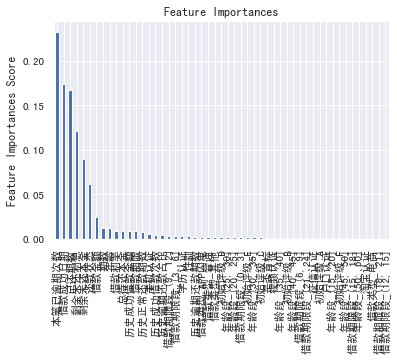

In [46]:
# 随机森林
rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, y_train)
    
df_prediction = rf.predict(x_test)
df_predprob = rf.predict_proba(x_test)[:, 1]

print('Accuracy : %.4g' % accuracy_score(y_test, df_prediction))
print('Precision : %.4g' % precision_score(y_test, df_prediction))
print('Recall : %.4g' % recall_score(y_test, df_prediction))
print('AUC Score (train) : %f' % roc_auc_score(y_test, df_predprob))

feat_imp = pd.Series(rf.feature_importances_, x_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importances Score')

> 随机森林的准确率和召回率都比逻辑回归高，但训练时间较长

Accuracy : 0.9975
Precision : 0.9664
Recall : 0.9161
AUC Score (train) : 0.997640


Text(0, 0.5, 'Feature Importances Score')

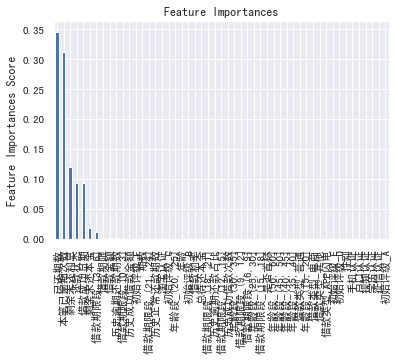

In [49]:
# 梯度提升决策树
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(x_train, y_train)
    
gbc_prediction = gbc.predict(x_test)
gbc_predprob = gbc.predict_proba(x_test)[:, 1]

print('Accuracy : %.4g' % accuracy_score(y_test, gbc_prediction))
print('Precision : %.4g' % precision_score(y_test, gbc_prediction))
print('Recall : %.4g' % recall_score(y_test, gbc_prediction))
print('AUC Score (train) : %f' % roc_auc_score(y_test, gbc_predprob))

feat_imp = pd.Series(gbc.feature_importances_, x_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importances Score')

> 梯度提升决策树预测效果和随机森林接近，但时间开销更多

In [51]:
# 使用网格搜索确定GBDT的参数，这里确定max_depth和min_samples_split
search_param = {'max_depth': range(10, 20, 2), 'min_samples_split': range(1000, 2000, 200)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, min_samples_leaf=50,  
                                    max_features='sqrt', subsample=0.8, random_state=10), 
                        param_grid=search_param, scoring='roc_auc', n_jobs=10, cv=5)
gsearch.fit(x_train, y_train)
print(gsearch.best_params_, gsearch.best_score_)

{'max_depth': 12, 'min_samples_split': 1800} 0.9992913906595546


In [54]:
gsearch_prediction = gsearch.predict(x_test)
gsearch_predict_proba= gsearch.predict_proba(x_test)[:, 1]

print('Accuracy : %.4g' % accuracy_score(y_test, gsearch_prediction))
print('Precision : %.4g' % precision_score(y_test, gsearch_prediction))
print('Recall : %.4g' % recall_score(y_test, gsearch_prediction))
print('AUC Score (train) : %f' % roc_auc_score(y_test, gsearch_predict_proba))

Accuracy : 0.998
Precision : 0.9708
Recall : 0.9354
AUC Score (train) : 0.998993


* 使用网格搜索得到的最优参数后得到了几个模型中最优的精度和召回率

In [57]:
# svm
model_svm = svm.SVC(kernel="sigmoid",probability=True)
model_svm.fit(x_train, y_train)
y_score = model_svm.predict_proba(x_test)[:, 1]
y_pre = model_svm.predict(x_test)

print('Accuracy : %.4g' % accuracy_score(y_test, y_pre))
print('Precision : %.4g' % precision_score(y_test, y_pre))
print('Recall : %.4g' % recall_score(y_test, y_pre))
print('AUC Score (train) : %f' % roc_auc_score(y_test, y_score))